In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import io
import boto3
import matplotlib.patches as mpatches
import os
import sys

ROOT_DIR = "/home/akhakhar/code/autoregreg"
sys.path.append(ROOT_DIR + "/utils")
import utils
from typing import List

/home/akhakhar/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def moving_average(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)


def plot_dif_y_axis(
    title: str,
    l_data: List,
    x_label: str,
    y_labels: List,
    colors: List,
    exponential_yaxis: bool,
):
    assert len(l_data) in [1, 2]
    fig, ax1 = plt.subplots()
    if exponential_yaxis:
        ax1.set_yscale("log", nonpositive="clip")
    ax1.yaxis.get_label().set_style("italic")
    ax1.yaxis.get_label().set_size(10)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_labels[0], color=colors[0])
    ax1.xaxis.get_label().set_style("italic")
    ax1.xaxis.get_label().set_size(10)
    ln_1 = []
    data = l_data[0]
    ln_1 += ax1.plot(
        data["x"],
        data["y"],
        marker=data["marker"] if "marker" in data else None,
        linestyle=data["linestyle"] if "linestyle" in data else "-",
        color=data["color"] if "color" in data else "black",
        linewidth=data["linewidth"] if "linewidth" in data else 2,
        label=data["label"] if "label" in data else None,
    )
    ax1.tick_params(axis="y", labelcolor=colors[0], labelsize=10)
    ax1.tick_params(axis="x", labelcolor="black", labelsize=10)
    lns = ln_1
    if "label" in data:
        ax1.legend(lns, [l.get_label() for l in lns])
    ax1.spines["top"].set_color((0.8, 0.8, 0.8))

    if len(l_data) == 2:
        ax2 = ax1.twinx()
        if exponential_yaxis:
            ax2.set_yscale("log", nonpositive="clip")
        ax2.set_ylabel(y_labels[1], color=colors[1])
        ln_2 = []
        data = l_data[1]
        ln_2 += ax2.plot(
            data["x"],
            data["y"],
            marker=data["marker"] if "marker" in data else None,
            linestyle=data["linestyle"] if "linestyle" in data else "-",
            color=data["color"] if "color" in data else "black",
            linewidth=data["linewidth"] if "linewidth" in data else 2,
            label=data["label"] if "label" in data else None,
        )
        ax2.tick_params(axis="y", labelcolor=colors[1], labelsize=10)
        ax2.yaxis.get_label().set_style("italic")
        ax2.yaxis.get_label().set_size(10)
        fig.tight_layout()

        lns = ln_1 + ln_2
        if "label" in data:
            ax2.legend(lns, [l.get_label() for l in lns])
        ax2.spines["top"].set_color((0.8, 0.8, 0.8))

    fig.suptitle(title, fontsize=10)

    plt.grid(linestyle="--", alpha=0.25)
    plt.xticks(fontsize=10)
    plt.tight_layout()
    fig = plt.gcf()
    # fig.set_size_inches(6, 10)
    plt.show()


def plot_wrapper(
    key: str,
    metrics: dict,
    y_labels: List,
    colors=["blue", "red"],
    bucket_name="arr-saved-experiment-data",
    local=False,
):
    print(key)
    data = None
    if local:
        data = utils.load_data(f"{ROOT_DIR}/results/{key}_mini_batch_metrics.bin")
    else:
        print(key + "_mini_batch_metrics.bin")
        data = utils.pull_from_s3(
            key + "_mini_batch_metrics.bin", bucket_name=bucket_name
        )
    metrics_to_plot = set([key for key in metrics])
    for metric in data:
        if metric in metrics_to_plot:
            print(metric, "plotting...")
            l_data = []
            if type(data[metric]) == dict:
                for target_indx in range(len(data[metric])):
                    l_data.append(
                        {
                            "x": [i for i in range(len(data[metric][target_indx]))],
                            "y": data[metric][target_indx],
                            "color": colors[target_indx],
                        }
                    )
            else:
                l_data.append(
                    {"x": [i for i in range(len(data[metric]))], "y": data[metric]}
                )
            plot_dif_y_axis(
                f"{key} {metric}",
                l_data,
                metric,
                y_labels,
                colors,
                metrics[metric]["exponential_yaxis"]
                if type(metrics[metric]) == dict
                and "exponential_yaxis" in metrics[metric]
                else False,
            )

one_dim_mae_sin_s_log_l_lr_0.1_seed_1
one_dim_mae_sin_s_log_l_lr_0.1_seed_1_mini_batch_metrics.bin
out_of_sample_error plotting...


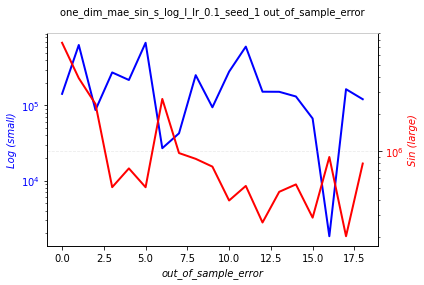

one_dim_mae_sin_s_log_l_lr_0.01_seed_1
one_dim_mae_sin_s_log_l_lr_0.01_seed_1_mini_batch_metrics.bin
out_of_sample_error plotting...


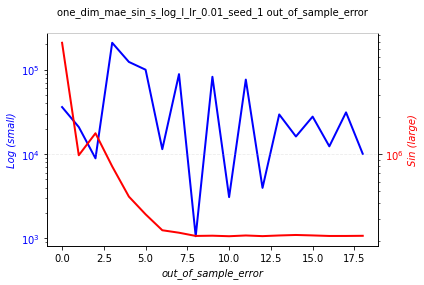

In [14]:
metrics = {
    "out_of_sample_error": {"exponential_yaxis": True},
    # "in_sample_error": {"exponential_yaxis": True},
}
for lr_str in [
    "0.1",
    "0.01",
    # "0.005",
    # "0.001",
    # "0.0005",
    # "0.0001",
    # "0.00005",
    # "0.00001",
    # "0.000005",
    # "0.000001",
]:
    experiment_name = "one_dim_mae_sin_s_log_l_lr_" + lr_str + "_seed_1"
    plot_wrapper(
        experiment_name,
        metrics,
        ["Log (small)", "Sin (large)"],
    )

one_dim_mae_sin_s_log_s_lr_0.1_seed_1
one_dim_mae_sin_s_log_s_lr_0.1_seed_1_mini_batch_metrics.bin
out_of_sample_error plotting...


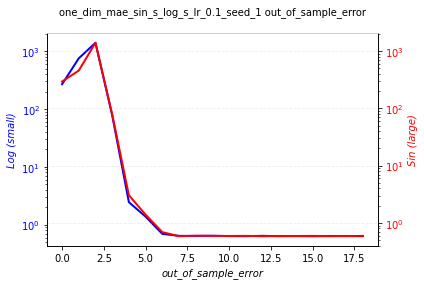

one_dim_mae_sin_s_log_s_lr_0.01_seed_1
one_dim_mae_sin_s_log_s_lr_0.01_seed_1_mini_batch_metrics.bin
out_of_sample_error plotting...


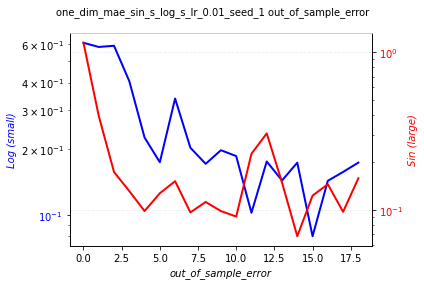

In [15]:
metrics = {
    "out_of_sample_error": {"exponential_yaxis": True},
    # "in_sample_error": {"exponential_yaxis": True},
}
for lr_str in [
    "0.1",
    "0.01",
    # "0.005",
    # "0.001",
    # "0.0005",
    # "0.0001",
    # "0.00005",
    # "0.00001",
    # "0.000005",
    # "0.000001",
]:
    experiment_name = "one_dim_mae_sin_s_log_s_lr_" + lr_str + "_seed_1"
    plot_wrapper(
        experiment_name,
        metrics,
        ["Log (small)", "Sin (large)"],
    )

mnist_mae_sin_s_log_s_lr_0.1_seed_1
mnist_mae_sin_s_log_s_lr_0.1_seed_1_mini_batch_metrics.bin
in_sample_error plotting...


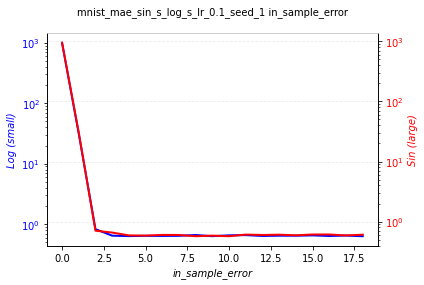

out_of_sample_error plotting...


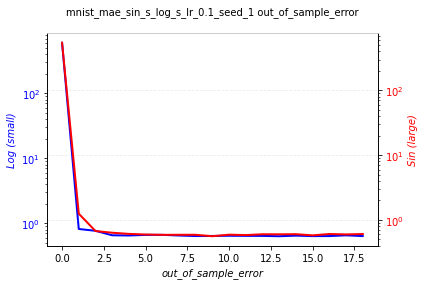

In [9]:
metrics = {
    "out_of_sample_error": {"exponential_yaxis": True},
    "in_sample_error": {"exponential_yaxis": True},
}
for lr_str in [
    "0.1",
    # "0.01",
    # "0.005",
    # "0.001",
    # "0.0005",
    # "0.0001",
    # "0.00005",
    # "0.00001",
    # "0.000005",
    # "0.000001",
]:
    experiment_name = "mnist_mae_sin_s_log_s_lr_" + lr_str + "_seed_1"
    plot_wrapper(
        experiment_name,
        metrics,
        ["Log (small)", "Sin (large)"],
    )

In [10]:
metrics = {
    # "train_loss_lst": {"exponential_yaxis": True},
    "out_of_sample_hard_mean_squared_error": {"exponential_yaxis": True},
    # "out_of_sample_soft_mean_squared_error": {"exponential_yaxis": True},
    "out_of_sample_mean_squared_error": {"exponential_yaxis": True},
}
for experiment_name in [
    "arr_log_s_sin_l_base_100_expmin_-3_expmax_4_lr_0.0001_seed_2_mini_batch",
    "mse_log_s_sin_l_lr_0.0001_seed_2_mini_batch",
    "arr_sin_s_log_l_base_100_expmin_-3_expmax_4_lr_0.0001_seed_2_mini_batch",
    "mse_sin_s_log_l_lr_0.0001_seed_2_mini_batch",
    "arr_sin_s_log_s_base_100_expmin_-3_expmax_4_lr_0.0001_seed_2_mini_batch",
    "mse_sin_s_log_s_lr_1e-05_seed_2_mini_batch",
]:
    plot_wrapper(
        experiment_name,
        metrics,
        ["target 0", "target 1"],
    )

arr_log_s_sin_l_base_100_expmin_-3_expmax_4_lr_0.0001_seed_2_mini_batch
arr_log_s_sin_l_base_100_expmin_-3_expmax_4_lr_0.0001_seed_2_mini_batch_mini_batch_metrics.bin


ClientError: An error occurred (404) when calling the HeadObject operation: Not Found

mnist_mse_log_s_sin_l_lr_0.005_seed_1
mnist_mse_log_s_sin_l_lr_0.005_seed_1_mini_batch_metrics.bin
out_of_sample_mean_squared_error plotting...


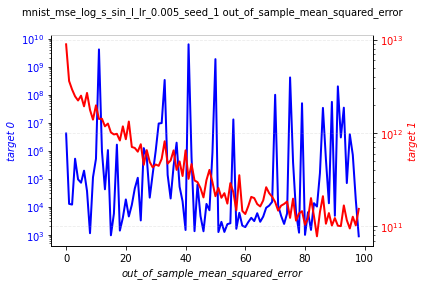

In [6]:
metrics = {
    # "train_loss_lst": {"exponential_yaxis": True},
    # "out_of_sample_hard_mean_squared_error": {"exponential_yaxis": True},
    # "out_of_sample_soft_mean_squared_error": {"exponential_yaxis": True},
    "out_of_sample_mean_squared_error": {"exponential_yaxis": True},
    # "in_sample_hard_mean_squared_error": {"exponential_yaxis": True},
}
for i in range(1, 2):
    experiment_name = "mnist_mse_log_s_sin_l_lr_0.005_seed_" + str(i)
    plot_wrapper(
        experiment_name,
        metrics,
        ["target 0", "target 1"],
    )